In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist

In [36]:
def get_maze(initPosn, goalPosn, radius, colors = [(255, 0, 0), (0, 0, 255)], maze_dim=(256, 256, 3)):
    if len(initPosn) != len(goalPosn) or len(initPosn) != len(radius) or len(initPosn) != len(colors):
        raise Exception("arrays are of incorrect sizes")
    maze = 255 * np.ones(shape = maze_dim).astype(np.uint8)
    
    for i in range(len(initPosn)):
        cv2.circle(maze, tuple(goalPosn[i]), 3, colors[i], -1)
        cv2.circle(maze, tuple(initPosn[i]), 3, colors[i], -1)

        # cv2.circle(maze, tuple(initPosn[i]), radius[i], colors[i], 1)
        
    r, c, _ = maze.shape
    maze = cv2.line(maze, (0,0), (0,r), (0,0,0), 2)
    maze = cv2.line(maze, (0,0), (c,0), (0,0,0), 2)
    maze = cv2.line(maze, (c,0), (c,r), (0,0,0), 3)
    maze = cv2.line(maze, (c,r), (0,r), (0,0,0), 3)
    return maze

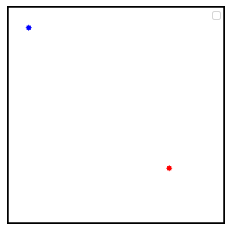

In [3]:
curr_pos = [[40, 40], [160, 160]] # (x, y)
radius = [10, 20]
goal_pos = [[190, 190], [25, 25]] # (x, y)
robots_color  = [(255, 0, 0), (0, 0, 255)]
maze = get_maze(curr_pos,goal_pos,radius)
plt.imshow(maze)
plt.axis('off')
plt.legend(["Start","End", "asdf"])
plt.show()

In [37]:
class VOSampler:
    def __init__(self,maze,curr_pos, goal_pos,radius, t=1, vmin=0.0, vmax=5.0, feasibility_radius=50):
        self.curr_pos = curr_pos
        self.goal_pos = goal_pos
        self.radius = radius
        self.t = t
        self.vmin = vmin
        self.vmax = vmax
        self.feasibility_radius = feasibility_radius
        self.maze = maze


    def get_velocities(self,i):
        x = np.arange(self.maze.shape[1])
        y = np.arange(self.maze.shape[0])
        dist = (x[np.newaxis,:]-self.curr_pos[i][0])**2 + (y[:,np.newaxis]-self.curr_pos[i][1])**2
        mask = np.logical_and((dist <= self.vmax**2), (dist >= self.vmin**2))
        idxs = np.where(mask)[::-1]
        return self.get_coords(idxs)

    def get_coords(self,idxs):
        co1,co2 = idxs
        res = []
        for a1,a2 in zip(co1,co2):
            res.append([a1,a2])
        res = np.array(res)
        return res

    def check_collision(self,i,velocity):
        for j in range(len(self.curr_pos)):
            if i != j and np.linalg.norm(np.array(self.curr_pos[i]) - np.array(self.curr_pos[j])) < self.feasibility_radius:
                x = np.arange(0, self.maze.shape[1])
                y = np.arange(0, self.maze.shape[0])
                mask = (x[np.newaxis,:]-self.curr_pos[j][0])**2 + (y[:,np.newaxis]-self.curr_pos[j][1])**2 < \
                        (self.radius[j] + self.radius[i])**2
                idx1 = np.ravel_multi_index(velocity.T[::-1, :], self.maze.shape[:2])
                idx2 = np.ravel_multi_index(self.get_coords(np.where(mask)).T, self.maze.shape[:2])
                tem = []
                for it1 in idx1:
                    if it1 not in idx2:
                        tem.append(it1)
                tem = np.array(tem)
                velocity = self.get_coords(np.unravel_index(tem,self.maze.shape[:2]))[:, ::-1]
        return velocity
            
    def get_path(self,only_final = 0,max_iter=1000):
        reached_robots = 0
        completed_robots = []
        prev_posn = self.curr_pos.copy()
        tot_robots = len(self.curr_pos)
        iter = 0
        while reached_robots < tot_robots and iter < max_iter:
            for i in range(len(self.curr_pos)):
                if i in completed_robots: continue
                x = np.arange(self.maze.shape[1])
                y = np.arange(self.maze.shape[0])
                allposs_velocity = self.get_velocities(i)
                no_coll_velocity = self.check_collision(i,allposs_velocity)

                all_dist = cdist(no_coll_velocity, np.array(self.goal_pos[i]).reshape(1, -1))
                min_idx = all_dist.argmin(axis = 0)
                self.curr_pos[i] = no_coll_velocity[min_idx].tolist()[0]

                if np.linalg.norm(np.array(self.curr_pos[i]) - np.array(self.goal_pos[i])) < 5: 
                    reached_robots += 1
                    completed_robots.append(i)
            
            maze_copy = self.maze.copy()
            for j in range(len(self.curr_pos)):
                cv2.circle(maze_copy, tuple(self.curr_pos[j]), self.radius[j], robots_color[j], -1)
                if j == 0:
                    cv2.line(self.maze, tuple(prev_posn[j]), tuple(self.curr_pos[j]), robots_color[j], 1)
            prev_posn = self.curr_pos.copy()
            if(only_final == 0):
                plt.imshow(maze_copy)
                plt.axis('off')
                plt.show()
            iter += 1
        if only_final:
            plt.imshow(maze_copy)
    #         plt.axis('off')
            plt.show()

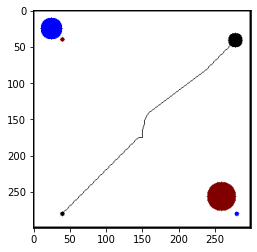

In [39]:
curr_pos = [ [40,280], [40, 40], [280, 280]]
radius = [10, 20, 15]
goal_pos = [ [280,40], [260, 260], [25, 25]]
robots_color  = [(0,0,0), (128, 0, 0), (0, 0, 255)]
maze =  get_maze(curr_pos, goal_pos,radius,robots_color,(300,300,3))
obj = VOSampler(maze,curr_pos, goal_pos,radius)
obj.get_path(1)

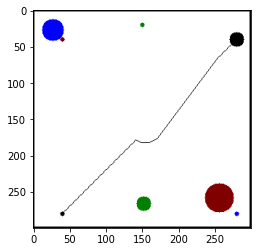

In [40]:
curr_pos = [ [40,280], [40, 40], [280, 280], [150, 20]]
radius = [10, 20, 15, 10]
goal_pos = [ [280,40], [260, 260], [25, 25], [150,270]]
robots_color  =  [(0,0,0), (128, 0, 0), (0, 0, 255), (0,128,0)]
maze =  get_maze(curr_pos, goal_pos,radius,robots_color,(300,300,3))
obj = VOSampler(maze,curr_pos, goal_pos,radius)
obj.get_path(1)